In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import xml.etree.ElementTree as ET

# Define class names (update as per your dataset)
class_labels = {"healthy": 0, "stressed": 1}

# Paths (modify as per your structure)
base_path = "/content/drive/MyDrive/MajorProject/RGB_Images"
xml_train_dir = f"{base_path}/Train_Labels_XML"
xml_test_dir = f"{base_path}/Test_Labels_XML"
output_train_dir = f"{base_path}/YOLO_labels/train"
output_test_dir = f"{base_path}/YOLO_labels/val"

os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

def convert_xml_to_yolo(xml_dir, output_dir):
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith(".xml"):
            continue

        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()

        img_w = int(root.find("size/width").text)
        img_h = int(root.find("size/height").text)

        annotations = []
        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in class_labels:
                continue

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            x_center = ((xmin + xmax) / 2) / img_w
            y_center = ((ymin + ymax) / 2) / img_h
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h

            annotations.append(f"{class_labels[class_name]} {x_center} {y_center} {width} {height}")

        # Save YOLO labels
        txt_filename = xml_file.replace(".xml", ".txt")
        with open(os.path.join(output_dir, txt_filename), "w") as f:
            f.write("\n".join(annotations))

convert_xml_to_yolo(xml_train_dir, output_train_dir)
convert_xml_to_yolo(xml_test_dir, output_test_dir)

print("XML conversion completed!")


XML conversion completed!


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Create YOLO dataset structure
dataset_path = f"{base_path}/dataset"
os.makedirs(f"{dataset_path}/images/train", exist_ok=True)
os.makedirs(f"{dataset_path}/images/val", exist_ok=True)
os.makedirs(f"{dataset_path}/labels/train", exist_ok=True)
os.makedirs(f"{dataset_path}/labels/val", exist_ok=True)

# Move images and labels
train_images = [f for f in os.listdir(f"{base_path}/Train_Images") if f.endswith(".jpg")]
train_files, val_files = train_test_split(train_images, test_size=0.2, random_state=42)

for img in train_files:
    shutil.copy(f"{base_path}/Train_Images/{img}", f"{dataset_path}/images/train/{img}")
    shutil.copy(f"{output_train_dir}/{img.replace('.jpg', '.txt')}", f"{dataset_path}/labels/train/{img.replace('.jpg', '.txt')}")

for img in val_files:
    shutil.copy(f"{base_path}/Train_Images/{img}", f"{dataset_path}/images/val/{img}")
    shutil.copy(f"{output_train_dir}/{img.replace('.jpg', '.txt')}", f"{dataset_path}/labels/val/{img.replace('.jpg', '.txt')}")

print("Dataset organized successfully!")


Dataset organized successfully!


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17485, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 17485 (delta 81), reused 31 (delta 31), pack-reused 17374 (from 3)
Receiving objects: 100% (17485/17485), 16.39 MiB | 17.39 MiB/s, done.
Resolving deltas: 100% (11986/11986), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s

In [ ]:
yaml_content = """train: /content/drive/MyDrive/MajorProject/RGB_Images/dataset/images/train
val: /content/drive/MyDrive/MajorProject/RGB_Images/dataset/images/val

nc: 2
names: ['healthy', 'stressed']
"""

with open("/content/yolov5/custom_data.yaml", "w") as f:
    f.write(yaml_content)

print("custom_data.yaml created!")


custom_data.yaml created!


In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/yolov5/custom_data.yaml --weights yolov5s.pt --cache


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-05-13 13:46:09.217957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747143969.432622    4699 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747143969.492779    4699 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --source /content/drive/MyDrive/MajorProject/RGB_Images/Test_Images


detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/MajorProject/RGB_Images/Test_Images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/60 /content/drive/MyDrive/MajorProject/RGB_Images/Test_Images/Image_001.jpg: 640x640 6 healthys, 3 stresseds, 11.5ms
image 2/60 /content/drive/MyDrive/MajorProject/RGB_Images/Test_Images/Image_002.jpg: 640x640 6 healthys, 5 stresseds, 11.5ms
image 3/60 /content/drive

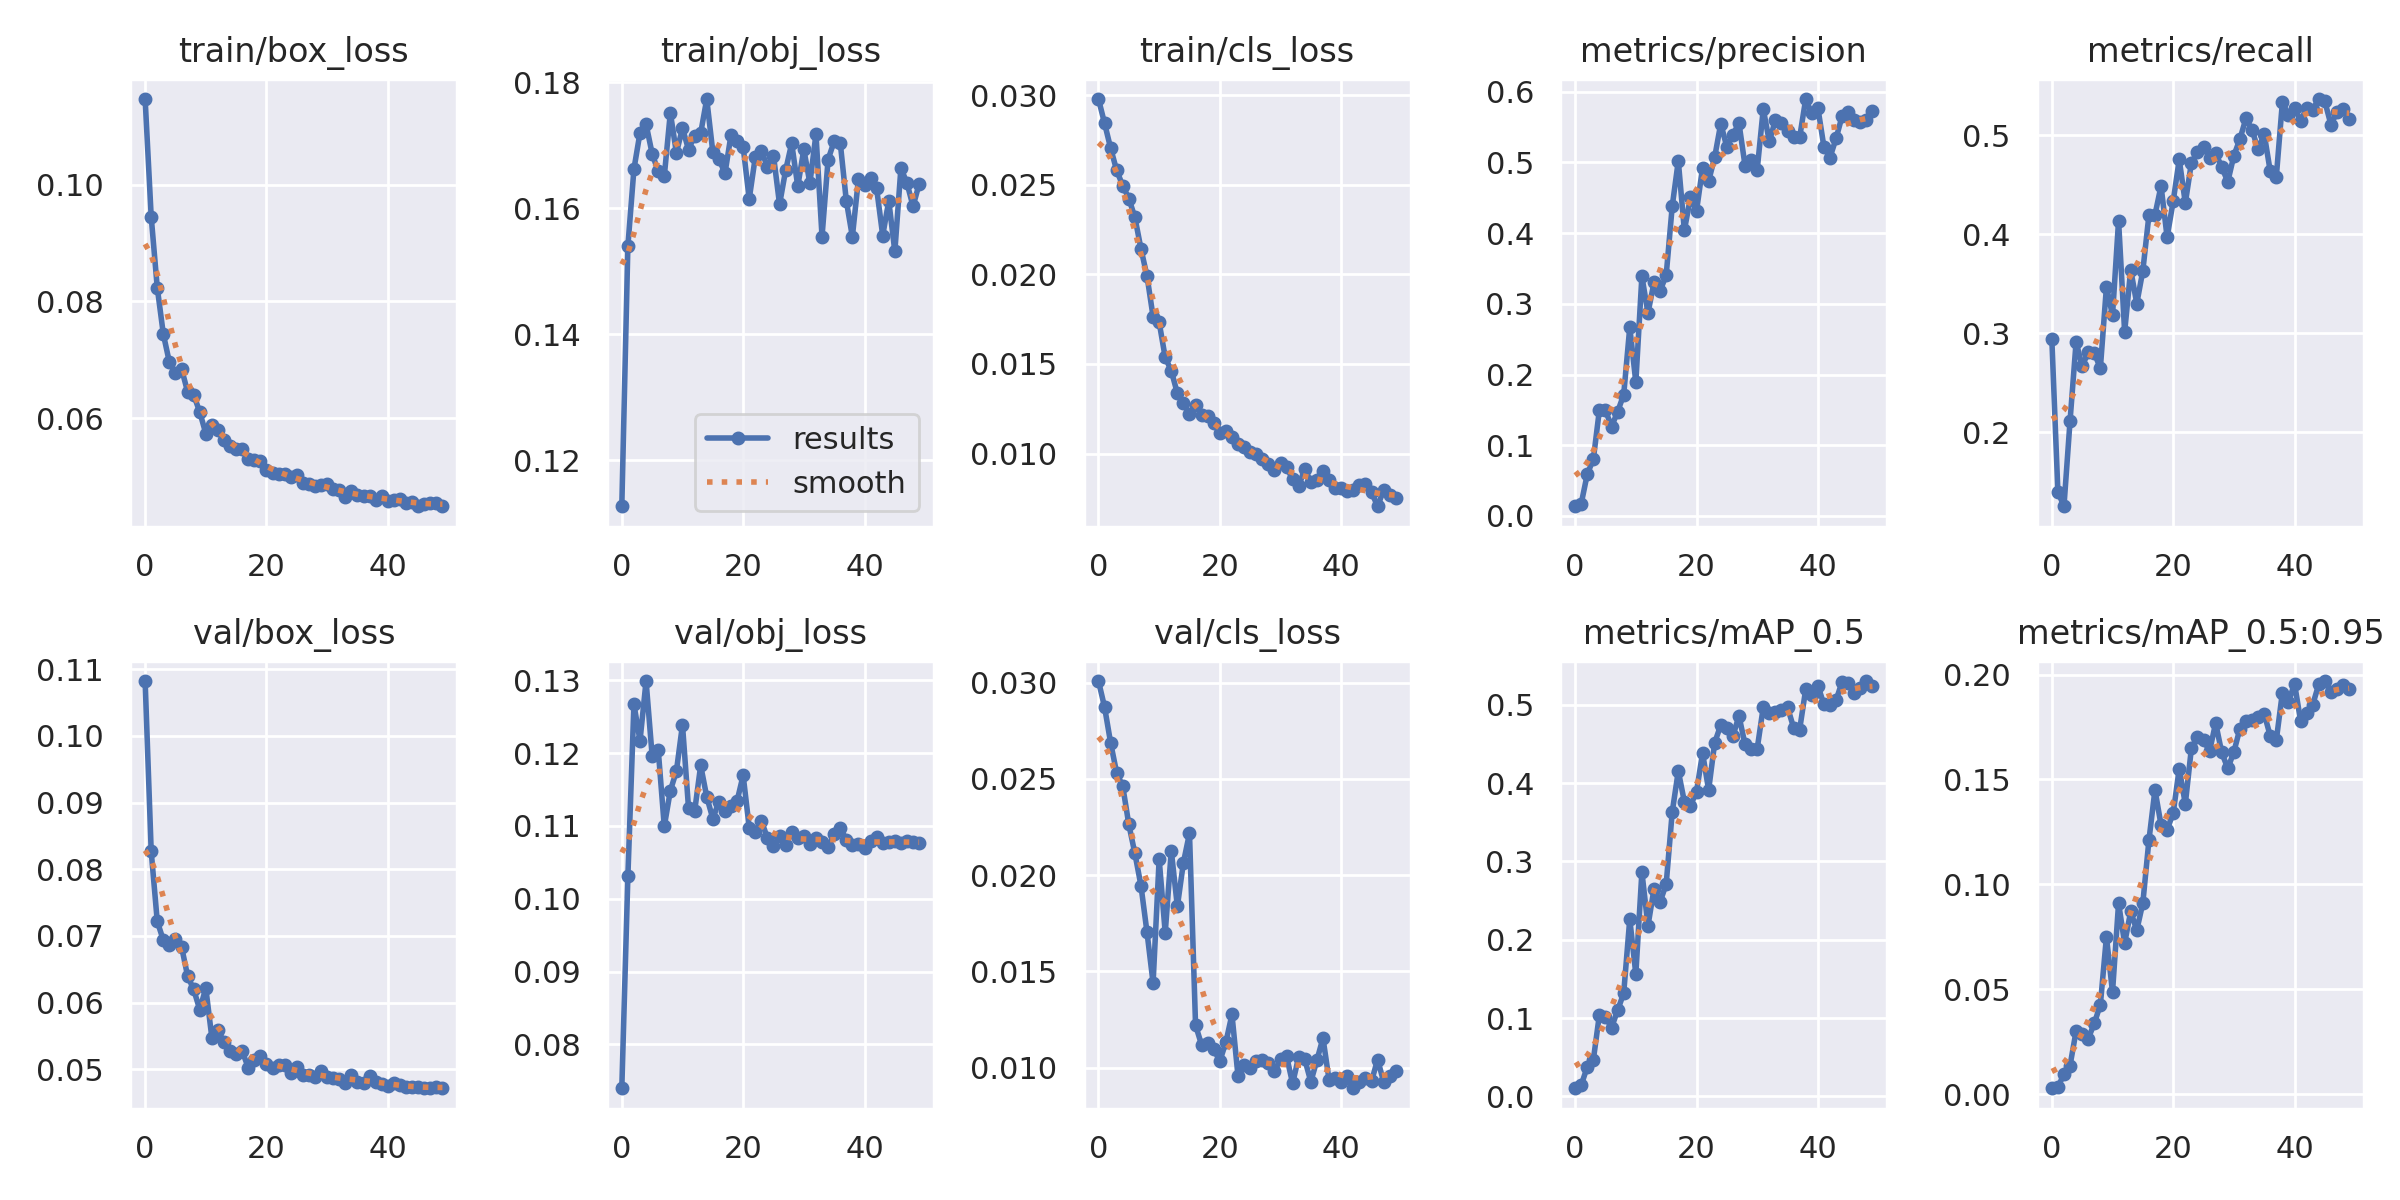

In [ ]:
from IPython.display import display, Image

# Show training results
display(Image(filename='runs/train/exp/results.png'))


In [ ]:
import pandas as pd

df = pd.read_csv('runs/train/exp/results.csv')
print("Available columns:\n", df.columns.tolist())


Available columns:
 ['               epoch', '      train/box_loss', '      train/obj_loss', '      train/cls_loss', '   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss', '        val/obj_loss', '        val/cls_loss', '               x/lr0', '               x/lr1', '               x/lr2']


In [ ]:
# Clean column names
df.columns = df.columns.str.strip()

# View cleaned column names
print("Cleaned columns:\n", df.columns.tolist())


Cleaned columns:
 ['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']


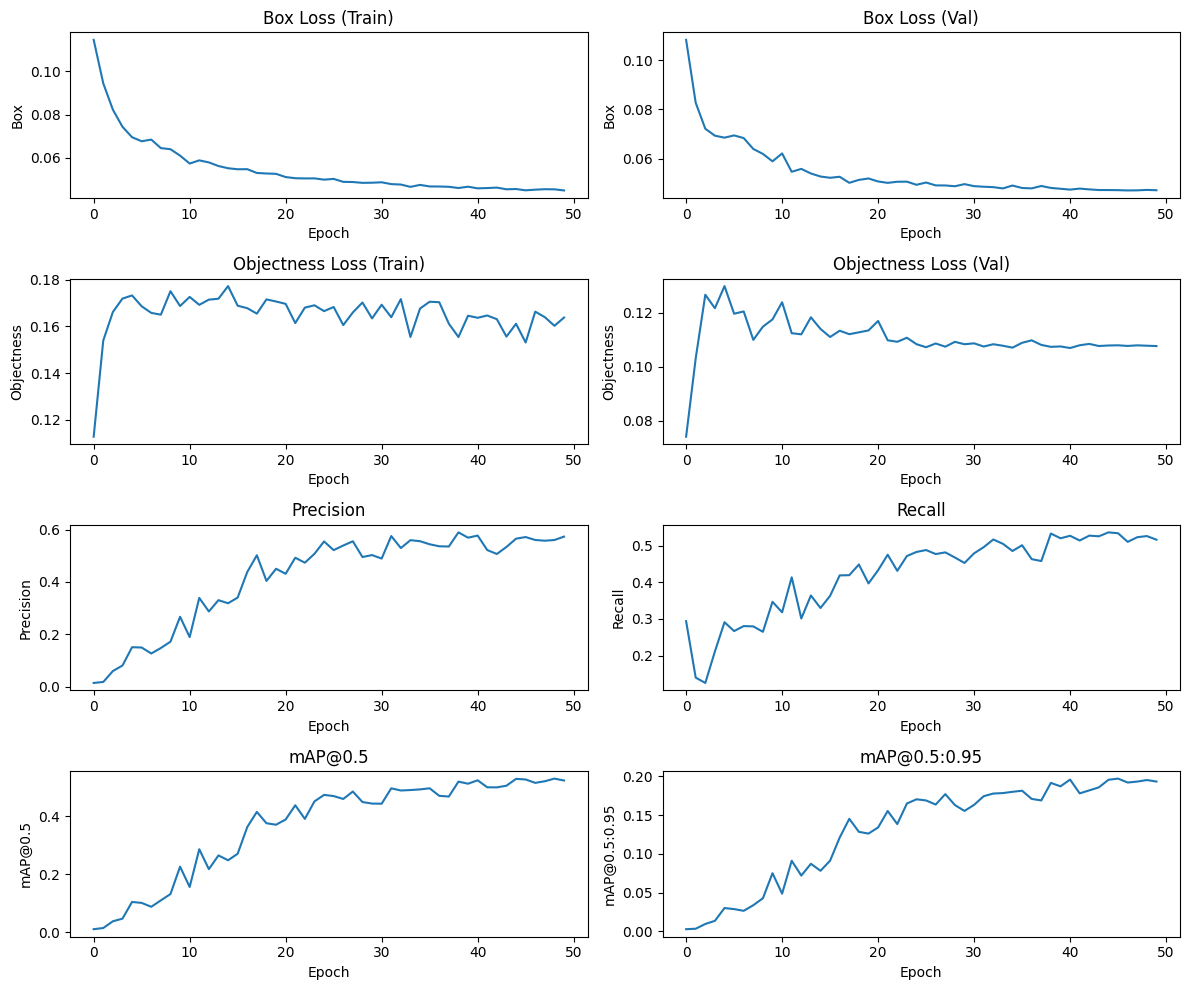

In [ ]:
import matplotlib.pyplot as plt

# Clean column names
df.columns = df.columns.str.strip()

# Plot with actual YOLOv5 columns
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
metrics = [
    ('train/box_loss', 'Box Loss (Train)'),
    ('val/box_loss', 'Box Loss (Val)'),
    ('train/obj_loss', 'Objectness Loss (Train)'),
    ('val/obj_loss', 'Objectness Loss (Val)'),
    ('metrics/precision', 'Precision'),
    ('metrics/recall', 'Recall'),
    ('metrics/mAP_0.5', 'mAP@0.5'),
    ('metrics/mAP_0.5:0.95', 'mAP@0.5:0.95')
]

for ax, (col, label) in zip(axs.ravel(), metrics):
    ax.plot(df.index, df[col])
    ax.set_title(label)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label.split()[0])

plt.tight_layout()
plt.show()


In [ ]:
!python val.py --weights runs/train/exp/weights/best.pt \
               --data /content/yolov5/custom_data.yaml \
               --img 640 --task val --save-txt --conf-thres 0.001



val: data=/content/yolov5/custom_data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/drive/MyDrive/MajorProject/RGB_Images/dataset/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100% 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:07<00:00,  3.77s/it]
                   all         60        816      0.571      0.535      0.529      0.197
               healthy         60        315      0.611      0.543      0.542    

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --source /content/drive/MyDrive/MajorProject/RGB_Images/Test_Images


detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/MajorProject/RGB_Images/Test_Images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/60 /content/drive/MyDrive/MajorProject/RGB_Images/Test_Images/Image_001.jpg: 640x640 6 healthys, 3 stresseds, 11.4ms
image 2/60 /content/drive/MyDrive/MajorProject/RGB_Images/Test_Images/Image_002.jpg: 640x640 6 healthys, 5 stresseds, 11.5ms
image 3/60 /content/drive

In [ ]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/yolov5/custom_data.yaml --img 640 --task val --save-txt


val: data=/content/yolov5/custom_data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/drive/MyDrive/MajorProject/RGB_Images/dataset/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100% 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:07<00:00,  3.66s/it]
                   all         60        816      0.571      0.535      0.529      0.197
               healthy         60        315      0.611      0.543      0.542    

In [ ]:
!ls runs/val/exp/labels | wc -l

ls: cannot access 'runs/val/exp/labels': No such file or directory
0


In [ ]:
!ls /content/drive/MyDrive/MajorProject/RGB_Images/dataset/labels/val | head


Image_005.txt
Image_006.txt
Image_014.txt
Image_019.txt
Image_028.txt
Image_032.txt
Image_033.txt
Image_035.txt
Image_049.txt
Image_054.txt


In [ ]:
true_labels, pred_labels = load_labels_and_preds(labels_dir, predictions_dir)

print(f"Found {len(true_labels)} ground-truth labels")
print(f"Found {len(pred_labels)} predicted labels")

if true_labels and pred_labels:
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["healthy", "stressed"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("Confusion matrix not generated — no valid labels or predictions found.")


[Warning] Missing prediction file for: Image_195.txt
[Warning] Missing prediction file for: Image_272.txt
[Warning] Missing prediction file for: Image_153.txt
[Warning] Missing prediction file for: Image_028.txt
[Warning] Missing prediction file for: Image_234.txt
[Warning] Missing prediction file for: Image_232.txt
[Warning] Missing prediction file for: Image_105.txt
[Warning] Missing prediction file for: Image_202.txt
[Warning] Missing prediction file for: Image_005.txt
[Warning] Missing prediction file for: Image_174.txt
[Warning] Missing prediction file for: Image_239.txt
[Warning] Missing prediction file for: Image_057.txt
[Warning] Missing prediction file for: Image_209.txt
[Warning] Missing prediction file for: Image_035.txt
[Warning] Missing prediction file for: Image_185.txt
[Warning] Missing prediction file for: Image_240.txt
[Warning] Missing prediction file for: Image_289.txt
[Warning] Missing prediction file for: Image_210.txt
[Warning] Missing prediction file for: Image_1

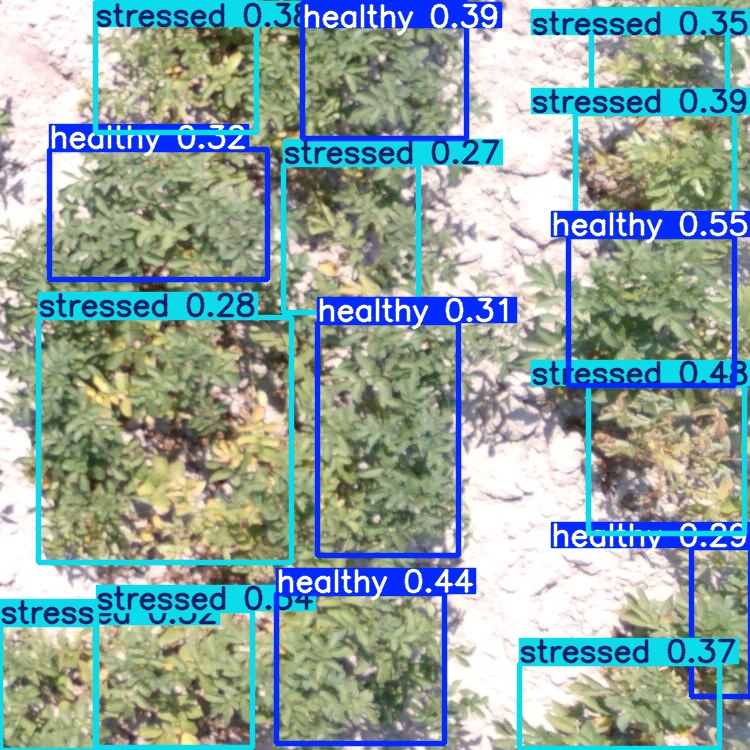

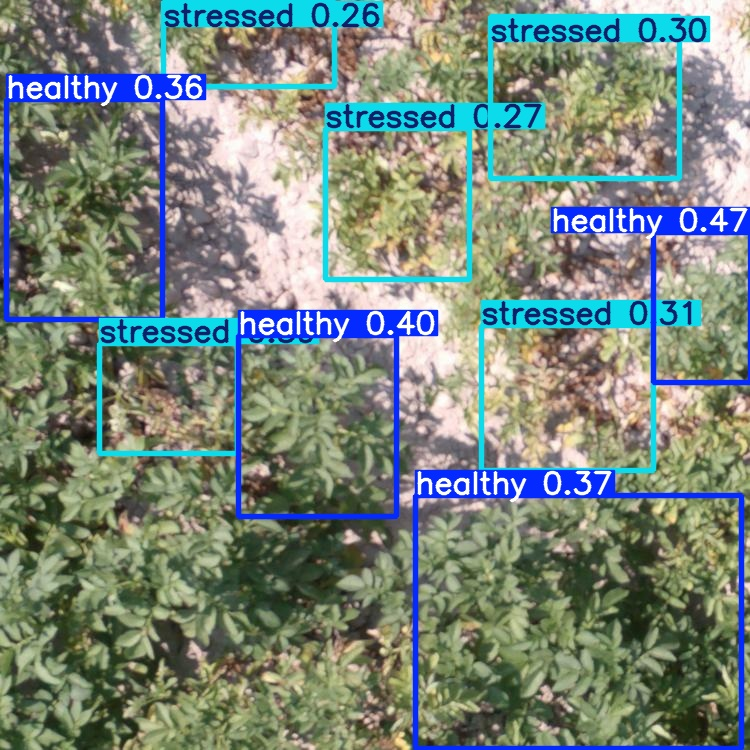

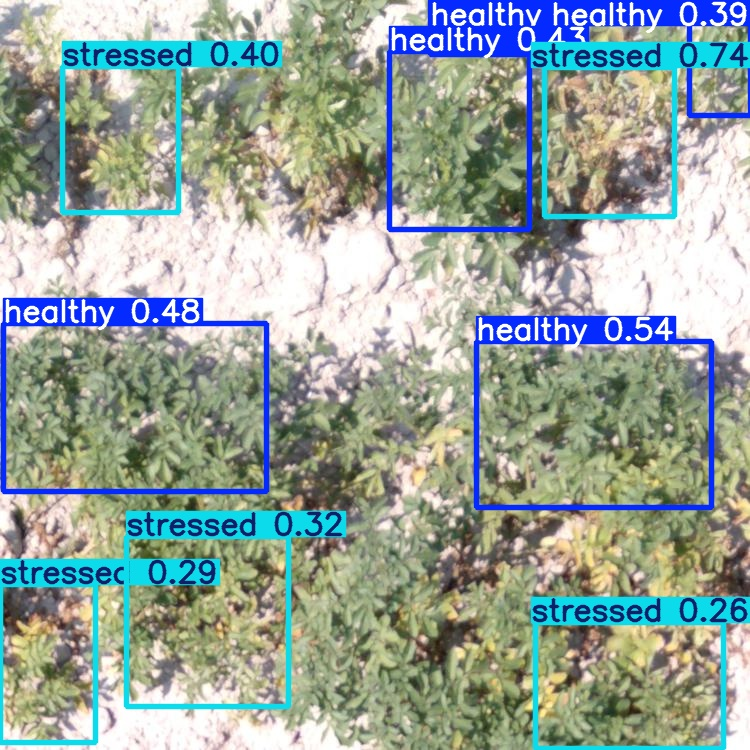

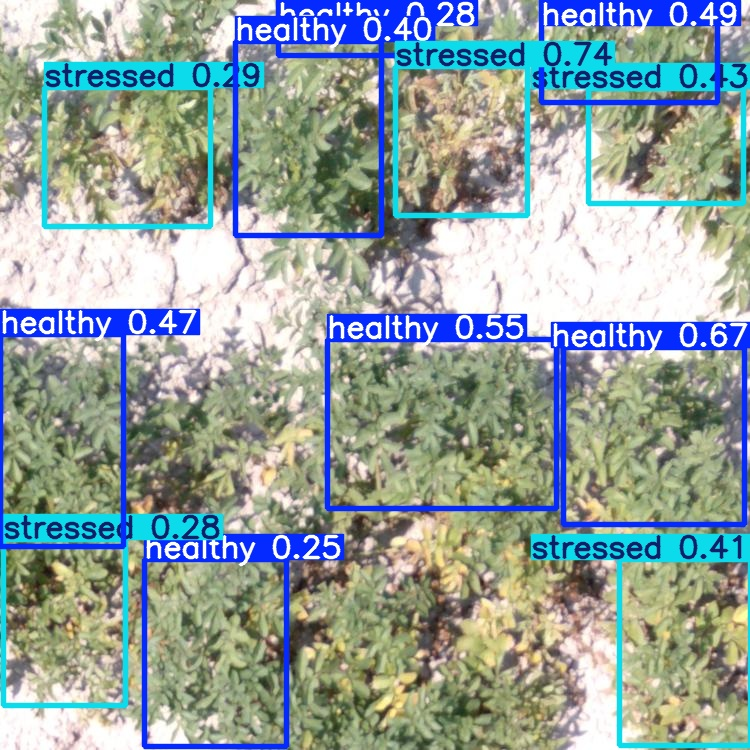

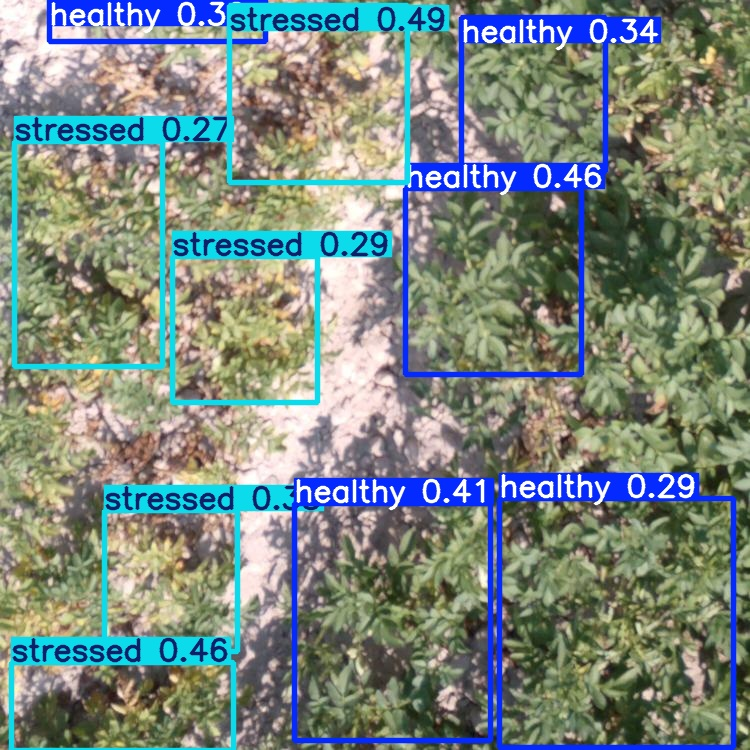

In [ ]:
import glob
from IPython.display import Image

# Get list of detected images
detected_images = glob.glob('runs/detect/exp/*.jpg')

# Display first 5 results
for img in detected_images[:5]:
    display(Image(filename=img))


In [ ]:
true_labels, pred_labels = load_labels_and_preds(labels_dir, predictions_dir)

print(f"Found {len(true_labels)} ground-truth labels")
print(f"Found {len(pred_labels)} predicted labels")

if true_labels and pred_labels:
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["healthy", "stressed"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("Confusion matrix not generated — no valid labels or predictions found.")


[Warning] Missing prediction file for: Image_195.txt
[Warning] Missing prediction file for: Image_272.txt
[Warning] Missing prediction file for: Image_153.txt
[Warning] Missing prediction file for: Image_028.txt
[Warning] Missing prediction file for: Image_234.txt
[Warning] Missing prediction file for: Image_232.txt
[Warning] Missing prediction file for: Image_105.txt
[Warning] Missing prediction file for: Image_202.txt
[Warning] Missing prediction file for: Image_005.txt
[Warning] Missing prediction file for: Image_174.txt
[Warning] Missing prediction file for: Image_239.txt
[Warning] Missing prediction file for: Image_057.txt
[Warning] Missing prediction file for: Image_209.txt
[Warning] Missing prediction file for: Image_035.txt
[Warning] Missing prediction file for: Image_185.txt
[Warning] Missing prediction file for: Image_240.txt
[Warning] Missing prediction file for: Image_289.txt
[Warning] Missing prediction file for: Image_210.txt
[Warning] Missing prediction file for: Image_1

In [ ]:
!python val.py --weights runs/train/exp/weights/best.pt \
               --data /content/yolov5/custom_data.yaml \
               --img 640 --task val --save-txt --conf-thres 0.001


val: data=/content/yolov5/custom_data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/drive/MyDrive/MajorProject/RGB_Images/dataset/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100% 60/60 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:06<00:00,  3.16s/it]
                   all         60        816      0.571      0.535      0.529      0.197
               healthy         60        315      0.611      0.543      0.542    

In [ ]:
!ls runs/val/exp/labels | sort


ls: cannot access 'runs/val/exp/labels': No such file or directory


In [ ]:
import os

gt_dir = '/content/drive/MyDrive/MajorProject/RGB_Images/dataset/labels/val'
pred_dir = 'runs/val/exp/labels'

gt_files = set(os.listdir(gt_dir))
pred_files = set(os.listdir(pred_dir)) if os.path.exists(pred_dir) else set()

common = gt_files & pred_files
missing_preds = gt_files - pred_files

print(f"Ground-truth files: {len(gt_files)}")
print(f"Prediction files  : {len(pred_files)}")
print(f"Matching files    : {len(common)}")
if missing_preds:
    print("Missing predictions for:")
    for f in sorted(missing_preds):
        print(f" - {f}")


Ground-truth files: 60
Prediction files  : 0
Matching files    : 0
Missing predictions for:
 - Image_005.txt
 - Image_006.txt
 - Image_014.txt
 - Image_019.txt
 - Image_028.txt
 - Image_032.txt
 - Image_033.txt
 - Image_035.txt
 - Image_049.txt
 - Image_054.txt
 - Image_057.txt
 - Image_064.txt
 - Image_076.txt
 - Image_078.txt
 - Image_080.txt
 - Image_081.txt
 - Image_082.txt
 - Image_087.txt
 - Image_090.txt
 - Image_099.txt
 - Image_100.txt
 - Image_104.txt
 - Image_105.txt
 - Image_108.txt
 - Image_117.txt
 - Image_125.txt
 - Image_126.txt
 - Image_147.txt
 - Image_153.txt
 - Image_155.txt
 - Image_157.txt
 - Image_163.txt
 - Image_170.txt
 - Image_174.txt
 - Image_180.txt
 - Image_185.txt
 - Image_195.txt
 - Image_202.txt
 - Image_204.txt
 - Image_209.txt
 - Image_210.txt
 - Image_213.txt
 - Image_223.txt
 - Image_226.txt
 - Image_228.txt
 - Image_231.txt
 - Image_232.txt
 - Image_233.txt
 - Image_234.txt
 - Image_235.txt
 - Image_239.txt
 - Image_240.txt
 - Image_247.txt
 - Imag

In [ ]:
true_labels, pred_labels = load_labels_and_preds(labels_dir, predictions_dir)

print(f"Found {len(true_labels)} ground-truth labels")
print(f"Found {len(pred_labels)} predicted labels")

if true_labels and pred_labels:
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["healthy", "stressed"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("Confusion matrix not generated — no valid labels or predictions found.")


[Warning] Missing prediction file for: Image_195.txt
[Warning] Missing prediction file for: Image_272.txt
[Warning] Missing prediction file for: Image_153.txt
[Warning] Missing prediction file for: Image_028.txt
[Warning] Missing prediction file for: Image_234.txt
[Warning] Missing prediction file for: Image_232.txt
[Warning] Missing prediction file for: Image_105.txt
[Warning] Missing prediction file for: Image_202.txt
[Warning] Missing prediction file for: Image_005.txt
[Warning] Missing prediction file for: Image_174.txt
[Warning] Missing prediction file for: Image_239.txt
[Warning] Missing prediction file for: Image_057.txt
[Warning] Missing prediction file for: Image_209.txt
[Warning] Missing prediction file for: Image_035.txt
[Warning] Missing prediction file for: Image_185.txt
[Warning] Missing prediction file for: Image_240.txt
[Warning] Missing prediction file for: Image_289.txt
[Warning] Missing prediction file for: Image_210.txt
[Warning] Missing prediction file for: Image_1

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

# Load true and predicted labels safely
def load_labels_and_preds(true_dir, pred_dir):
    true_labels = []
    pred_labels = []

    for label_file in os.listdir(true_dir):
        if not label_file.endswith(".txt"):
            continue

        true_path = os.path.join(true_dir, label_file)
        pred_path = os.path.join(pred_dir, label_file)

        if not os.path.exists(pred_path):
            print(f"[Warning] Missing prediction file for: {label_file}")
            continue

        with open(true_path) as f_true, open(pred_path) as f_pred:
            true_lines = f_true.readlines()
            pred_lines = f_pred.readlines()

            if len(true_lines) != len(pred_lines):
                print(f"[Warning] Mismatch in number of objects in: {label_file}")
                continue

            for true_line, pred_line in zip(true_lines, pred_lines):
                try:
                    true_labels.append(int(true_line.strip().split()[0]))
                    pred_labels.append(int(pred_line.strip().split()[0]))
                except Exception as e:
                    print(f"[Error] Failed to parse line in {label_file}: {e}")

    return true_labels, pred_labels

# Directories
labels_dir = '/content/drive/MyDrive/MajorProject/RGB_Images/dataset/labels/val'
predictions_dir = 'runs/val/exp/labels'

# Load
true_labels, pred_labels = load_labels_and_preds(labels_dir, predictions_dir)

# Check and plot
if true_labels and pred_labels:
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["healthy", "stressed"])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("Confusion matrix not generated — no valid labels or predictions found.")


[Warning] Missing prediction file for: Image_195.txt
[Warning] Missing prediction file for: Image_272.txt
[Warning] Missing prediction file for: Image_153.txt
[Warning] Missing prediction file for: Image_028.txt
[Warning] Missing prediction file for: Image_234.txt
[Warning] Missing prediction file for: Image_232.txt
[Warning] Missing prediction file for: Image_105.txt
[Warning] Missing prediction file for: Image_202.txt
[Warning] Missing prediction file for: Image_005.txt
[Warning] Missing prediction file for: Image_174.txt
[Warning] Missing prediction file for: Image_239.txt
[Warning] Missing prediction file for: Image_057.txt
[Warning] Missing prediction file for: Image_209.txt
[Warning] Missing prediction file for: Image_035.txt
[Warning] Missing prediction file for: Image_185.txt
[Warning] Missing prediction file for: Image_240.txt
[Warning] Missing prediction file for: Image_289.txt
[Warning] Missing prediction file for: Image_210.txt
[Warning] Missing prediction file for: Image_1